In [6]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import random
from itertools import chain, combinations, tee
import time

# Load Input Data:

In [7]:
vot_pdf = np.genfromtxt('../original_code/VOT_distr.csv', delimiter=',')[1:]
vots = []
vot_p = []
for row in vot_pdf:
    vots.append(row[0])
    vot_p.append(row[1])
print(vot_p)
print()
vot_p=vot_p/np.sum(vot_p)
print(vot_p)

[0.01, 0.02, 0.01, 0.02, 0.02, 0.02, 0.02, 0.04, 0.02, 0.07, 0.02, 0.07, 0.16, 0.13, 0.05, 0.25, 0.03, 0.05]

[0.00990099 0.01980198 0.00990099 0.01980198 0.01980198 0.01980198
 0.01980198 0.03960396 0.01980198 0.06930693 0.01980198 0.06930693
 0.15841584 0.12871287 0.04950495 0.24752475 0.02970297 0.04950495]


# Travel time functions:

In [8]:
###### BPR Parameters ###### 
bpr_true_capacity = 66
bpr_true_fftt = 60*22/67
bpr_true_alpha = 0.2

def true_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, alpha = bpr_true_alpha):
    """
    Find the (exact) travel time on an edge given an edge flow
    """

    return fftt * (1+alpha*(flow_val/capacity)**6)

###### Approximation Parameters ###### 
const_multiplier = 1
cap_thresh_multiplier = 0.7835
apx_slope = 0.314

def apx_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, 
                a = const_multiplier, cap_thresh = cap_thresh_multiplier, b = apx_slope):
    """
    Find the (approximate) travel time on an edge given an edge flow
    """
    
    if flow_val <= cap_thresh*capacity:
        return a*fftt
    else:
        return a*fftt + b*(flow_val - cap_thresh*capacity)

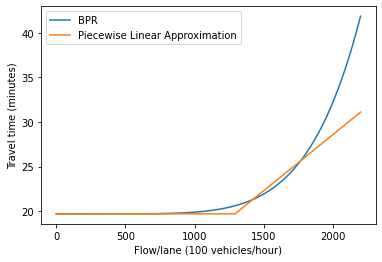

In [9]:
###### Check plots of BPR and approximation ###### 
multiplier = 100/4 # converts from 100 vehicles/hour --> vehicle/hour per lane

x =  np.linspace(0,int(np.round(88*multiplier,0)),int(np.round(89*2*multiplier,0)))
y = [true_bpr_cost(i, capacity = bpr_true_capacity*multiplier) for i in x]

plt.plot(x, y,label='BPR')

y_apx = [apx_bpr_cost(i,capacity = bpr_true_capacity*multiplier, b = apx_slope/multiplier) for i in x]

plt.plot(x, y_apx,label='Piecewise Linear Approximation')
plt.xlabel("Flow/lane (100 vehicles/hour)")
plt.ylabel("Travel time (minutes)")
plt.legend(loc='upper left')

# Generate Demand Profile:

In [10]:
num_eligible_factor = 10.0

###### Specify parameters for problem ###### 
T = 5 # Time Horizon
tau_arr = 20*np.linspace(0, 1, 21)[0:] # Toll discretization
print('Tau:\n {}'.format(tau_arr))
print()

B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 
print('B:\n {}'.format(B_arr))
print()

num_total = 8000 # number of users
num_eligible =int( num_total*.17) # number of eligible users
num_ineligible = num_total-num_eligible # number of ineligible users

###### VoT information ###### 
vot_all = np.sort(np.round(np.random.choice(vots, size = num_total, p=vot_p),2)/60) # generate baseline VoT for all users
vot_all_days = np.empty(shape=(num_total,T)) 
count=0
for v in vot_all:
    if count < num_eligible:
        vot_all_days[count,:]=[v*num_eligible_factor
                               for t in range(T)] # VoT of eligible users does not vary over time periods
    else:
        vot_all_days[count,:]=list((1+0.25*(np.random.random_sample(size=T)-0.5))*v) # VoT of ineligible users varies over time periods
    count+=1
    
vot_eligible = vot_all_days[:num_eligible,:]
vot_ineligible= vot_all_days[num_eligible:,:]

print('Eligible vot range:\n {} ({} $/hr), {} ({} $/hr)'.format(np.min(vot_eligible),60*np.min(np.round(vot_eligible,2)),np.max(np.round(vot_eligible,2)),60*np.max(np.round(vot_eligible,2))))
print()
print('Ineligible vot range:\n {}({} $/hr), {} ({} $/hr)'.format(np.min(np.round(vot_ineligible,2)),60*np.min(np.round(vot_ineligible,2)),np.max(np.round(vot_ineligible,2)),60*np.max(np.round(vot_ineligible,2))))
print()
print('Mean vot:\n {} $/hr; median: {} $/hr'.format(60*np.round(np.mean(vot_all_days),2),60*np.round(np.median(vot_all_days),2)))

Tau:
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]

B:
 [ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85.
 90.]

Eligible vot range:
 0.2 (12.0 $/hr), 2.4 (144.0 $/hr)

Ineligible vot range:
 0.21(12.6 $/hr), 2.7 (162.0 $/hr)

Mean vot:
 56.4 $/hr; median: 48.0 $/hr


Text(0, 0.5, '% of population')

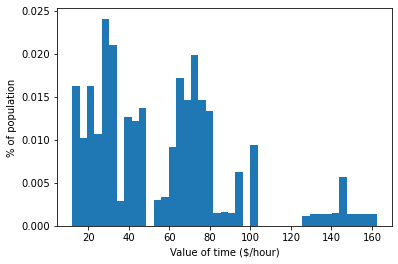

In [11]:
###### Check VoT distribution ###### 
plt.hist(vot_all_days.flatten()*60,bins=41,density=True)
plt.xlabel("Value of time ($/hour)")
plt.ylabel("% of population")

Text(0, 0.5, '% of population')

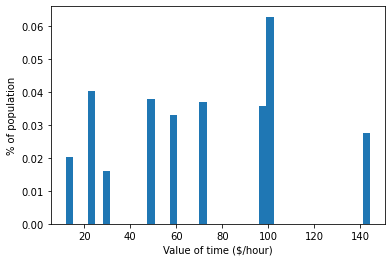

In [19]:
###### Check VoT, eligible distribution ###### 
plt.hist(vot_eligible.flatten()*60,bins=41,density=True)
plt.xlabel("Value of time ($/hour)")
plt.ylabel("% of population")

Text(0, 0.5, '% of population')

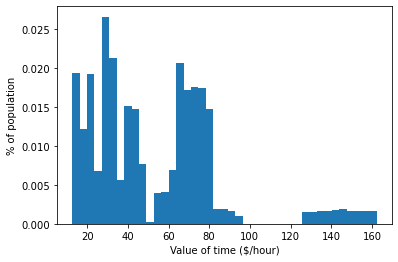

In [20]:
###### Check VoT, eligible distribution ###### 
plt.hist(vot_ineligible.flatten()*60,bins=41,density=True)
plt.xlabel("Value of time ($/hour)")
plt.ylabel("% of population")

# Define Social Objectives of Interest:

In [12]:
###### Estimate VoT percentiles for ineligible group ###### 
percentiles = {}
thresh = 10
for p in range(11):
    print(np.round(np.percentile(vot_ineligible,p*10)*60,2))
    percentiles[p*10]=np.percentile(vot_ineligible,p*10)

12.64
19.14
26.84
30.66
37.86
44.58
63.87
68.96
74.75
80.36
162.25


# Solver 1, Budget:

In [13]:
def OptPL_budget(toll, B, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity, c_2 = bpr_true_capacity, 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope, b_2 = apx_slope, is_pure = False):
    """
    Function to solve convex optimization problem given a particular toll and budget value
    """
    
    # Initialize model
    m1 = gp.Model()
    # Add variables to model
#     users_in = m1.addVars(num_ineligible, 3, T, name = 'ineligible_val', lb = 0.0, ub = 2.0)
#     edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = 0.0, ub = num_ineligible * 2.0)
#     users_el = m1.addVars(3, T, name = 'eligible_allocation', lb = 0.0, ub = 2.0)
    # Add variables for piecewise affine approximation
#     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
    
#     # Add variables for piecewise affine approximation
#     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
    users_in = m1.addVars(num_ineligible, 3, T, name = 'ineligible_val', lb = -10000.0, ub = 10000.0)
    edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = -10000.0, ub = 10000.0)
    users_el = m1.addVars(3, T, name = 'eligible_allocation', lb = -10000.0, ub = 10000.0)
    eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = -10000.0, ub = 10000.0)   

    ## Add constraints to Model 
    
    # Total edge flow, express lane:
    m1.addConstrs((edge_flows[0, t] == sum(users_in[i, 0, t] for i in range(num_ineligible)) + \
                  users_el[0, t] + sum(users_in[i, 1, t] for i in range(num_ineligible)) + \
                  users_el[1, t] for t in range(T)))
    # Total edge flow, general purpose lane:
    m1.addConstrs((edge_flows[1, t] == sum(users_in[i, 2, t] for i in range(num_ineligible)) + \
                  users_el[2, t] for t in range(T)))
    
    # Non-negativity of all flows, and zero flow for "eligible users in ineligible groups":
    m1.addConstrs((users_in[i, j, t]>=0 for i in range(num_ineligible) for j in range(3) for t in range(T)))
    m1.addConstrs((users_in[i, 0, t]==0 for i in range(num_ineligible) for t in range(T)))
    m1.addConstrs((users_el[j, t]>=0 for j in range(3) for t in range(T)))
    # Just to compare with original code:
    if is_pure:
        m1.addConstrs((users_el[1, t]==0 for t in range(T)))
    
    # Every eligible and ineligible user is assigned to one of three options: \
    # (express paying, express with credit, non-express)
    m1.addConstrs((sum(users_in[i, j, t] for j in range(3)) == 1 for i in range(num_ineligible) for t in range(T)))
    m1.addConstrs((sum(users_el[j, t] for j in range(3)) == num_eligible for t in range(T)))
    
    # Budget constraint satisfaction:
    if toll != 0:
        m1.addConstr((sum(toll*users_el[0, t] for t in range(T)) <= B * num_eligible))
    
    # Piecewise affine approximation:
    m1.addConstrs((eps_flows[j, t] >= 0 for j in range(2) for t in range(T))) # Must be at least 0
    m1.addConstrs((eps_flows[0, t] >= edge_flows[0, t] - cap_thresh*c_1 for t in range(T))) # Must be at least flow - capacity
    m1.addConstrs((eps_flows[1, t] >= edge_flows[1, t] - cap_thresh*c_2 for t in range(T))) # Must be at least flow - capacity
    
    # Set Objective
    m1.setObjective(sum(a*fftt_1*(edge_flows[0, t]) + b_1*(eps_flows[0, t]**2)/2  
                        + a*fftt_2*(edge_flows[1, t]) + b_2*(eps_flows[1, t]**2)/2 
                        + sum( toll*users_in[i,1,t]/vot_ineligible[i,t] for i in range(num_ineligible))
                        + sum( toll*users_el[1,t]/(vot_eligible[i,t]*num_eligible) for i in range(num_eligible) ) 
        for t in range(T)), GRB.MINIMIZE)
    
    m1.update()
    
    return m1

In [14]:
def _extract_solution_budget(m, num_ineligible = num_ineligible):
    """
    Get solution from optimization model
    """
    users_in = [v.x for v in m.getVars() if v.VarName.find("ineligible_val") != -1]
    users_el = [v.x for v in m.getVars() if v.VarName.find("eligible_allocation") != -1]
    edge_flows = [v.x for v in m.getVars() if v.VarName.find("edge_flows") != -1]
    eps_flows = [v.x for v in m.getVars() if v.VarName.find("eps_flows") != -1]
    
    users_in = np.reshape(users_in, (num_ineligible, 3, T))
    users_el = np.reshape(users_el, (3, T))
    edge_flows = np.reshape(edge_flows, (2, T))
    eps_flows = np.reshape(eps_flows, (2, T))

    solution = {
        "users_in": users_in,
        "users_el": users_el,
        "edge_flows": edge_flows,
        "eps_flows": eps_flows
    }
    return solution

In [15]:
def to_str(num):
    num = int(num)
    
    # For any number < 100:
    if num < 10:
        return str(0) + str(num)
    else:
        return str(num)

# Solve Optimization Problem for Discretized Grid:

## Case 1 - Budget:

In [16]:
# tau_arr = 20 * np.linspace(0, 1, 21)[0:]
# B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) 

# print("tau_arr:\n", tau_arr)
# print()
# print("B_arr:\n", B_arr)

In [17]:
tau_arr = 20 * np.linspace(0, 1, 11)[0:] 
B_arr = np.linspace(0, tau_arr[-1]*4, 9)

print("tau_arr:\n", tau_arr)
print()
print("B_arr:\n", B_arr)

tau_arr:
 [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20.]

B_arr:
 [ 0. 10. 20. 30. 40. 50. 60. 70. 80.]


In [18]:
t_1 = time.time()

demand_multiplier = [25, 75]

# For saving data:

is_pure = False
# is_pure = True

num_eligible_factor_as_str = str(int(num_eligible_factor))

if num_eligible_factor == 0.0:
    path_directory = "/Users/chih-yuanchiu/Desktop/Code/CBCP_Credit_Discount/data/data_budget"
else:
    path_directory = "/Users/chih-yuanchiu/Desktop/Code/CBCP_Credit_Discount/data/data_budget_" + num_eligible_factor_as_str + "x"

if is_pure:
    path_directory += "_pure/"
else:
    path_directory += "/"

    
row_names = ["Edge flows", "Eps flows", "Eligible User Flows"]
row_names += ["Ineligible User Flow, " + str(k) for k in list(range(num_ineligible + 1))[1:]]

column_names = []
workday_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
lane_names = ["Express (Credit)", "Express (Paying)", "General Purpose"]
for workday_index, workday in enumerate(workday_names):
    for lane_index, lane in enumerate(lane_names):
        column_names.append(workday + ", " + lane)
        
## Toll and budget lists:
tau_arr = 20 * np.linspace(0, 1, 21)[0:] # Toll discretization
B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 

## For debugging purposes, truncate tau_arr and B_arr:
# tau_arr = [0.0, 5.0, 10.0, 15.0, 20.0]
# B_arr = [0.0, 5.0, 10.0, 15.0, 20.0]
# tau_arr = [20]
# tau_arr = 20 * np.linspace(0, 1, 11)[0:] 
# B_arr = np.linspace(0, tau_arr[-1]*4, 9)
# tau_arr = [2.0]
# B_arr = [0.0]


total_count = len(tau_arr) * len(B_arr)

for toll_idx, toll in enumerate(tau_arr):
    for budget_idx, budget in enumerate(B_arr):
        
        if budget >= toll * T or budget == 0 or toll == 0:
            continue
        
        print()
        print("Toll:", toll)
        print("Budget:", budget)
        print()
        
        # Construct optimization problem:
        m_budget = OptPL_budget(toll, budget, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible,  \
                                vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, \
                                fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity*demand_multiplier[0], c_2 = bpr_true_capacity*demand_multiplier[1], \
                                a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope/demand_multiplier[0], b_2 = apx_slope/(demand_multiplier[1]), \
                                is_pure = is_pure)

        # Solve optimization problem:
        m_budget.optimize()
        
        print("Optimal solution obtained:", m_budget.status == GRB.OPTIMAL)
        
        # Extract Solution:
        solution_set = _extract_solution_budget(m_budget)
        
        if toll == tau_arr[0]:
            print()
            print("Edge flows:", solution_set["edge_flows"])
            print()
        
        # Storing data:
        data_edge_flows = np.hstack((np.zeros((5, 1)), solution_set["edge_flows"].T)).reshape(15)
        data_eps_flow = np.hstack((np.zeros((5, 1)), solution_set["eps_flows"].T)).reshape(15)
        data_users_el = solution_set["users_el"].T.reshape(15)
        data_users_in = solution_set["users_in"].transpose(0, 2, 1).reshape((num_ineligible, 5*3))
        data = np.vstack((data_edge_flows, data_eps_flow, data_users_el, data_users_in))
        
        if is_pure:
            file_name = path_directory + "toll_" + to_str(toll) + "_budget_pure" + to_str(budget) + ".csv"
        else:
            file_name = path_directory + "toll_" + to_str(toll) + "_budget_" + to_str(budget) + ".csv"
        df = pd.DataFrame(data, columns = column_names, index = row_names)        
        df.to_csv(file_name)


t_2 = time.time()
print("Run time:", t_2 - t_1)


Toll: 2.0
Budget: 5.0

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-03
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x9cabe65f
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [7e-01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 7e+03]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.22s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iterat

  19   8.60284060e+05  8.60284014e+05  9.39e-08 5.68e-14  6.99e-07     0s
  20   8.60284040e+05  8.60284033e+05  3.91e-11 5.68e-14  1.03e-07     0s
  21   8.60284037e+05  8.60284037e+05  1.54e-10 5.68e-14  1.11e-10     0s

Barrier solved model in 21 iterations and 0.37 seconds (0.25 work units)
Optimal objective 8.60284037e+05

Optimal solution obtained: True

Toll: 3.0000000000000004
Budget: 15.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xb0744649
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 2e+04]
Presolve removed 166025 rows and 66400 columns
Pre

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xb00d0031
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 1e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.18s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.71133767e+09 -4.28579129e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1   3.54942913e+05 -1.33549165e+07  6.36e+03 5.63e-01  1.19e+03     0s
   2   1.18655791e+06 -3.35135086e+

  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 1e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.14s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.14125487e+09 -4.28310651e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -3.71374405e+04 -1.35178014e+07  6.36e+03 5.64e-01  1.19e+03     0s
   2   1.19334661e+06 -3.30748105e+06  2.06e+02 1.83e-02  9.69e+01     0s
   3   9.87019140e+05 -3.99404471e+05  1.53e+01 1.36e-03  2.17e+01     0s
   4   9.23866450e+05  7.20245824e+05  2.03e+00 1.80e-04  3.09e+00     0s
   5   9.06801527e+05  7.42886047e+05  1.42e+00 1.26e-04  2.48e+00     0s
   


Toll: 6.000000000000001
Budget: 5.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xfb609ef8
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [2e+00, 3e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 7e+03]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.14s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Ite

  10   8.74152805e+05  8.72420773e+05  2.68e-05 2.37e-09  2.61e-02     0s
  11   8.73523386e+05  8.73126435e+05  4.36e-06 3.85e-10  5.97e-03     0s
  12   8.73367090e+05  8.73306979e+05  3.34e-07 2.95e-11  9.04e-04     0s
  13   8.73346729e+05  8.73329660e+05  1.02e-07 6.49e-12  2.57e-04     0s
  14   8.73340162e+05  8.73336753e+05  2.26e-07 8.74e-13  5.13e-05     0s
  15   8.73338676e+05  8.73338313e+05  9.63e-08 8.53e-14  5.47e-06     0s
  16   8.73338502e+05  8.73338490e+05  7.80e-07 8.53e-14  1.87e-07     0s
  17   8.73338496e+05  8.73338496e+05  4.64e-10 8.53e-14  1.28e-08     0s
  18   8.73338496e+05  8.73338496e+05  1.09e-10 5.68e-14  1.31e-11     0s

Barrier solved model in 18 iterations and 0.30 seconds (0.23 work units)
Optimal objective 8.73338496e+05

Optimal solution obtained: True

Toll: 6.000000000000001
Budget: 20.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 ph

   4   9.51836708e+05  6.68315808e+05  2.09e+00 1.85e-04  4.30e+00     0s
   5   9.37848782e+05  7.52044022e+05  1.33e+00 1.18e-04  2.81e+00     0s
   6   9.15837113e+05  7.06617708e+05  1.18e+00 1.04e-04  3.17e+00     0s
   7   9.08592054e+05  7.34772161e+05  9.71e-01 8.60e-05  2.63e+00     0s
   8   8.82955702e+05  7.73596527e+05  8.64e-02 7.65e-06  1.65e+00     0s
   9   8.76122597e+05  7.95950767e+05  5.20e-02 4.61e-06  1.21e+00     0s
  10   8.73223877e+05  8.34639387e+05  3.78e-03 3.35e-07  5.80e-01     0s
  11   8.65315697e+05  8.47782658e+05  8.56e-04 7.58e-08  2.64e-01     0s
  12   8.59375244e+05  8.57149917e+05  4.01e-05 3.55e-09  3.35e-02     0s
  13   8.58592205e+05  8.57998887e+05  2.51e-06 1.91e-10  8.92e-03     0s
  14   8.58417098e+05  8.58174169e+05  8.54e-07 7.54e-11  3.65e-03     0s
  15   8.58414521e+05  8.58176595e+05  8.36e-07 7.38e-11  3.58e-03     0s
  16   8.58389813e+05  8.58195875e+05  5.68e-07 5.03e-11  2.92e-03     0s
  17   8.58367614e+05  8.58215232e+05 

   1  -8.24173706e+05 -1.34842740e+07  6.37e+03 5.65e-01  1.19e+03     0s
   2   1.19927342e+06 -3.26297431e+06  2.08e+02 1.84e-02  9.70e+01     0s
   3   1.01475098e+06 -3.56599788e+05  1.01e+01 8.96e-04  2.12e+01     0s
   4   9.49365102e+05  7.05600207e+05  1.58e+00 1.40e-04  3.70e+00     0s
   5   9.24723649e+05  7.33665123e+05  1.06e+00 9.35e-05  2.89e+00     0s
   6   9.30763138e+05  7.69496438e+05  5.86e-01 5.19e-05  2.43e+00     0s
   7   9.21099375e+05  8.01016027e+05  3.66e-01 3.25e-05  1.81e+00     0s
   8   9.19503590e+05  8.05260016e+05  3.48e-01 3.09e-05  1.72e+00     0s
   9   8.95393361e+05  8.36229521e+05  6.53e-02 5.78e-06  8.91e-01     0s
  10   8.84014962e+05  8.72345534e+05  1.01e-02 8.98e-07  1.76e-01     0s
  11   8.81466689e+05  8.76353057e+05  3.69e-03 3.27e-07  7.70e-02     0s
  12   8.79621433e+05  8.78602117e+05  5.18e-04 4.59e-08  1.53e-02     0s
  13   8.79275142e+05  8.78930224e+05  1.42e-04 1.25e-08  5.19e-03     0s
  14   8.79153494e+05  8.79042908e+05 

   0  -3.00113066e+09 -4.27773937e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -8.55815234e+05 -1.34249975e+07  6.40e+03 5.67e-01  1.20e+03     0s
   2   1.14425730e+06 -3.41568218e+06  3.25e+02 2.88e-02  1.15e+02     0s
   3   1.03232013e+06 -1.05087936e+06  4.50e+00 3.98e-04  3.17e+01     0s
   4   9.54510766e+05  7.31356936e+05  3.73e-01 3.30e-05  3.36e+00     0s
   5   9.04515801e+05  7.39470523e+05  2.01e-01 1.78e-05  2.49e+00     0s
   6   8.99704803e+05  7.59643376e+05  1.70e-01 1.50e-05  2.11e+00     0s
   7   8.86728116e+05  8.06945254e+05  6.65e-02 5.89e-06  1.20e+00     0s
   8   8.73478702e+05  8.51337349e+05  1.16e-02 1.03e-06  3.33e-01     0s
   9   8.68535721e+05  8.56855242e+05  5.03e-03 4.45e-07  1.76e-01     0s
  10   8.65744638e+05  8.61296453e+05  1.41e-03 1.25e-07  6.69e-02     0s
  11   8.65583118e+05  8.61506996e+05  1.29e-03 1.14e-07  6.13e-02     0s
  12   8.65170135e+05  8.61952765e+05  8.87e-04 7.86e-08  4.84e-02     0s
  13   8.64953869e+05  8.62173839e+05 

  20   8.95534284e+05  8.95531902e+05  1.23e-06 5.68e-14  3.58e-05     0s
  21   8.95533933e+05  8.95532219e+05  1.47e-06 5.68e-14  2.58e-05     0s
  22   8.95533656e+05  8.95532469e+05  1.19e-06 8.53e-14  1.79e-05     0s
  23   8.95533370e+05  8.95532734e+05  2.22e-06 1.14e-13  9.56e-06     0s
  24   8.95533063e+05  8.95533028e+05  5.31e-08 1.14e-13  5.23e-07     0s
  25   8.95533048e+05  8.95533043e+05  2.10e-10 1.14e-13  8.43e-08     0s
  26   8.95533045e+05  8.95533045e+05  3.56e-09 1.14e-13  1.17e-10     0s

Barrier solved model in 26 iterations and 0.47 seconds (0.27 work units)
Optimal objective 8.95533045e+05

Optimal solution obtained: True

Toll: 8.0
Budget: 10.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x0d16bb33
Mo

  14   8.79399552e+05  8.79395033e+05  1.05e-06 1.14e-13  6.80e-05     0s
  15   8.79398570e+05  8.79395961e+05  9.01e-07 8.53e-14  3.92e-05     0s
  16   8.79397631e+05  8.79396863e+05  6.27e-07 1.14e-13  1.16e-05     0s
  17   8.79397307e+05  8.79397173e+05  7.15e-09 1.14e-13  2.02e-06     0s
  18   8.79397246e+05  8.79397234e+05  4.88e-10 1.14e-13  1.71e-07     0s
  19   8.79397240e+05  8.79397240e+05  4.43e-09 1.14e-13  7.77e-09     0s

Barrier solved model in 19 iterations and 0.39 seconds (0.24 work units)
Optimal objective 8.79397240e+05

Optimal solution obtained: True

Toll: 8.0
Budget: 25.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x04e3e6e2
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix rang

   9   8.67713779e+05  8.59697795e+05  5.01e-04 4.44e-08  1.21e-01     0s
  10   8.65640118e+05  8.62819009e+05  1.57e-04 1.39e-08  4.24e-02     0s
  11   8.65589895e+05  8.62874387e+05  1.51e-04 1.33e-08  4.08e-02     0s
  12   8.65300987e+05  8.63172375e+05  1.18e-04 1.04e-08  3.20e-02     0s
  13   8.65138369e+05  8.63318260e+05  9.38e-05 8.31e-09  2.74e-02     0s
  14   8.64832094e+05  8.63631737e+05  6.07e-05 5.38e-09  1.81e-02     0s
  15   8.64663822e+05  8.63795802e+05  4.35e-05 3.85e-09  1.31e-02     0s
  16   8.64546084e+05  8.63906572e+05  3.19e-05 2.82e-09  9.62e-03     0s
  17   8.64466899e+05  8.63979914e+05  2.41e-05 2.13e-09  7.33e-03     0s
  18   8.64409010e+05  8.64032246e+05  1.86e-05 1.64e-09  5.67e-03     0s
  19   8.64365100e+05  8.64071543e+05  1.45e-05 1.28e-09  4.42e-03     0s
  20   8.64335368e+05  8.64095450e+05  1.07e-05 9.41e-10  3.61e-03     0s
  21   8.64300275e+05  8.64124706e+05  6.72e-06 5.93e-10  2.64e-03     0s
  22   8.64269846e+05  8.64152024e+05 


                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.86094353e+09 -4.27235650e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -1.60066114e+06 -1.33554699e+07  6.38e+03 5.65e-01  1.19e+03     0s
   2   1.21318074e+06 -3.21543800e+06  2.04e+02 1.80e-02  9.63e+01     0s
   3   1.04931156e+06 -4.34329051e+05  3.17e+01 2.81e-03  2.43e+01     0s
   4   9.73439820e+05  5.75438418e+05  7.76e+00 6.87e-04  6.19e+00     0s
   5   9.52194898e+05  6.08718187e+05  5.26e+00 4.66e-04  5.30e+00     0s
   6   9.26849946e+05  8.46606708e+05  9.83e-01 8.71e-05  1.22e+00     0s
   7   9.03797693e+05  8.73203305e+05  2.75e-01 2.43e-05  4.64e-01     0s
   8   8.94361539e+05  8.86211414e+05  4.90e-02 4.34e-06  1.23e-01     0s
   9   8.91071092e+05  8.89295957e+05  7.94e-03 7.03e-07  2.68e-02     0s
  10   8.90217130e+05  8.89938660e+05  5.27e-04 4.67e-08  4.20e-03     0s
  11   8.90113941e+05  8.90036624e+05  1.10e-04 9.71e-09  1

   3   1.04529671e+06 -3.87331329e+05  4.41e+00 3.91e-04  2.18e+01     0s
   4   9.74720829e+05  6.40273307e+05  9.54e-01 8.45e-05  5.05e+00     0s
   5   9.18121859e+05  6.69929535e+05  2.02e-01 1.79e-05  3.74e+00     0s
   6   9.39924814e+05  7.48598525e+05  9.18e-02 8.13e-06  2.88e+00     0s
   7   9.19988790e+05  7.79605099e+05  5.10e-02 4.52e-06  2.11e+00     0s
   8   8.92214871e+05  8.41050067e+05  5.59e-08 4.53e-12  7.70e-01     0s
   9   8.81453490e+05  8.64152596e+05  2.91e-08 1.46e-12  2.60e-01     0s
  10   8.78648530e+05  8.68544647e+05  3.76e-08 6.25e-13  1.52e-01     0s
  11   8.77855460e+05  8.69732046e+05  5.79e-08 4.62e-13  1.22e-01     0s
  12   8.76662363e+05  8.71577186e+05  1.11e-08 2.84e-13  7.65e-02     0s
  13   8.76019505e+05  8.72521617e+05  3.42e-08 1.92e-13  5.26e-02     0s
  14   8.75606421e+05  8.73091655e+05  5.66e-08 1.42e-13  3.78e-02     0s
  15   8.75307050e+05  8.73486648e+05  3.30e-08 1.14e-13  2.74e-02     0s
  16   8.75059588e+05  8.73789731e+05 

   3   1.06035124e+06 -8.50080719e+05  4.60e+00 4.07e-04  2.91e+01     0s
   4   9.78960650e+05  6.20583146e+05  7.33e-01 6.49e-05  5.41e+00     0s
   5   9.11457291e+05  7.44167232e+05  9.38e-02 8.31e-06  2.52e+00     0s
   6   8.95089603e+05  7.88407925e+05  5.86e-02 5.19e-06  1.61e+00     0s
   7   8.79586756e+05  8.51947547e+05  1.22e-02 1.09e-06  4.16e-01     0s
   8   8.71190273e+05  8.58003169e+05  3.88e-03 3.44e-07  1.98e-01     0s
   9   8.68272455e+05  8.60773760e+05  1.98e-03 1.76e-07  1.13e-01     0s
  10   8.65584601e+05  8.63963860e+05  1.60e-05 1.41e-09  2.44e-02     0s
  11   8.65329992e+05  8.64149367e+05  8.95e-06 7.81e-10  1.78e-02     0s
  12   8.65162221e+05  8.64289597e+05  5.68e-06 4.99e-10  1.31e-02     0s
  13   8.65052030e+05  8.64384271e+05  3.85e-06 3.38e-10  1.00e-02     0s
  14   8.64935310e+05  8.64495695e+05  2.49e-06 2.19e-10  6.61e-03     0s
  15   8.64881596e+05  8.64545331e+05  1.92e-06 1.66e-10  5.06e-03     0s
  16   8.64831586e+05  8.64590870e+05 

  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 2e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.36s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -4.29086573e+09 -4.26966900e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -1.99143550e+06 -1.33061140e+07  6.38e+03 5.65e-01  1.19e+03     0s
   2   1.22197634e+06 -3.18241459e+06  1.96e+02 1.74e-02  9.50e+01     0s
   3   1.06416487e+06 -4.86779872e+05  3.59e+01 3.18e-03  2.57e+01     0s
   4   9.85378040e+05  5.20094965e+05  9.99e+00 8.85e-04  7.30e+00     0s
   5   9.67203738e+05  5.57316152e+05  7.44e+00 6.59e-04  6.38e+00     0s
   

 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -4.29088547e+09 -4.26967303e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -2.02318479e+06 -1.34123686e+07  6.40e+03 5.67e-01  1.20e+03     0s
   2   1.18396432e+06 -3.23462535e+06  2.40e+02 2.13e-02  1.02e+02     0s
   3   1.05444321e+06 -2.38996622e+05  4.42e+00 3.91e-04  1.97e+01     0s
   4   9.83812060e+05  5.50869270e+05  1.29e+00 1.15e-04  6.55e+00     0s
   5   9.29209534e+05  7.20946562e+05  4.00e-01 3.54e-05  3.14e+00     0s
   6   9.15243643e+05  8.20806624e+05  4.00e-07 3.54e-11  1.42e+00     0s
   7   8.88865050e+05  8.65472138e+05  8.36e-08 6.67e-12  3.52e-01     0s
   8   8.83650303e+05  8.74343049e+05  6.06e-08 2.13e-12  1.40e-01     0s
   9   8.81750862e+05  8.77056419e+05  1.20e-08 9.27e-13  7.06e-02     0s
  10   8.80538523e+05  8.78631700e+05  7.14e-08 2.88e-13  

  21   8.69705319e+05  8.69556907e+05  1.56e-05 1.38e-09  2.23e-03     0s
  22   8.69696259e+05  8.69566720e+05  1.26e-05 1.11e-09  1.95e-03     0s
  23   8.69681586e+05  8.69582360e+05  9.57e-06 8.47e-10  1.49e-03     0s
  24   8.69673950e+05  8.69590464e+05  8.03e-06 7.11e-10  1.26e-03     0s
  25   8.69663337e+05  8.69601608e+05  5.89e-06 5.22e-10  9.29e-04     0s
  26   8.69655756e+05  8.69609593e+05  3.90e-06 3.45e-10  6.94e-04     0s
  27   8.69648576e+05  8.69617191e+05  2.09e-06 1.84e-10  4.72e-04     0s
  28   8.69644798e+05  8.69621105e+05  1.36e-06 1.19e-10  3.56e-04     0s
  29   8.69641027e+05  8.69624965e+05  9.04e-07 7.99e-11  2.42e-04     1s
  30   8.69638780e+05  8.69627286e+05  2.10e-06 4.75e-11  1.73e-04     1s
  31   8.69636930e+05  8.69629218e+05  4.34e-07 1.71e-13  1.16e-04     1s
  32   8.69634920e+05  8.69631233e+05  2.66e-06 1.14e-13  5.55e-05     1s
  33   8.69633769e+05  8.69632388e+05  3.05e-06 1.71e-13  2.08e-05     1s
  34   8.69633236e+05  8.69632920e+05 

  10   9.05734498e+05  9.05624763e+05  6.97e-07 6.09e-11  1.65e-03     0s
  11   9.05702169e+05  9.05663149e+05  2.50e-07 1.92e-11  5.87e-04     0s
  12   9.05690140e+05  9.05677009e+05  7.37e-07 6.05e-12  1.98e-04     0s
  13   9.05686139e+05  9.05681541e+05  6.68e-07 1.90e-12  6.92e-05     0s
  14   9.05685085e+05  9.05682727e+05  9.69e-07 8.56e-13  3.55e-05     0s
  15   9.05684649e+05  9.05683221e+05  1.40e-06 4.05e-13  2.15e-05     0s
  16   9.05684077e+05  9.05683842e+05  2.53e-08 1.71e-13  3.54e-06     0s
  17   9.05683991e+05  9.05683929e+05  6.60e-09 1.71e-13  9.30e-07     0s
  18   9.05683960e+05  9.05683959e+05  1.58e-10 1.71e-13  1.34e-08     1s
  19   9.05683960e+05  9.05683960e+05  3.66e-09 1.14e-13  2.21e-10     1s

Barrier solved model in 19 iterations and 0.52 seconds (0.24 work units)
Optimal objective 9.05683960e+05

Optimal solution obtained: True

Toll: 11.0
Budget: 15.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model

  16   8.89806400e+05  8.89799967e+05  3.34e-07 1.25e-11  9.68e-05     0s
  17   8.89804320e+05  8.89801982e+05  2.01e-07 3.86e-12  3.52e-05     0s
  18   8.89803572e+05  8.89802708e+05  4.21e-07 9.02e-13  1.30e-05     0s
  19   8.89803185e+05  8.89803089e+05  1.09e-07 1.71e-13  1.45e-06     0s
  20   8.89803144e+05  8.89803129e+05  1.17e-08 1.14e-13  2.20e-07     0s
  21   8.89803137e+05  8.89803137e+05  1.31e-09 1.71e-13  3.60e-10     0s

Barrier solved model in 21 iterations and 0.34 seconds (0.25 work units)
Optimal objective 8.89803137e+05

Optimal solution obtained: True

Toll: 11.0
Budget: 30.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x1df8033a
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix ran

  15   8.74963062e+05  8.74240073e+05  4.84e-08 1.14e-13  1.09e-02     0s
  16   8.74879275e+05  8.74298006e+05  7.19e-08 1.14e-13  8.74e-03     0s
  17   8.74812739e+05  8.74343109e+05  1.04e-07 1.14e-13  7.06e-03     0s
  18   8.74765846e+05  8.74374754e+05  8.47e-08 1.14e-13  5.88e-03     0s
  19   8.74726514e+05  8.74400916e+05  1.90e-07 1.14e-13  4.90e-03     0s
  20   8.74697604e+05  8.74420120e+05  1.97e-07 1.14e-13  4.17e-03     0s
  21   8.74671131e+05  8.74437573e+05  1.76e-07 1.14e-13  3.51e-03     0s
  22   8.74650794e+05  8.74450952e+05  1.03e-07 1.14e-13  3.01e-03     0s
  23   8.74632951e+05  8.74462477e+05  9.53e-08 1.14e-13  2.56e-03     0s
  24   8.74615113e+05  8.74473925e+05  5.09e-07 1.14e-13  2.12e-03     0s
  25   8.74601807e+05  8.74482428e+05  6.73e-07 1.14e-13  1.80e-03     0s
  26   8.74591427e+05  8.74489035e+05  5.12e-07 1.14e-13  1.54e-03     0s
  27   8.74580120e+05  8.74496233e+05  5.89e-07 1.14e-13  1.26e-03     1s
  28   8.74572807e+05  8.74500861e+05 


Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x1174374f
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+00, 6e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 7e+03]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.23s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -5.15069477e+09 -4.26429170e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -2.74973776e+06 -1.29607123e+07  6.37e+03 5.64e-01  1.19e+03     0s
   2   1.25832958e+06 -3.10933729e

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -5.15071684e+09 -4.26429524e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -2.78566528e+06 -1.32822913e+07  6.39e+03 5.66e-01  1.19e+03     0s
   2   1.23135472e+06 -3.12577938e+06  1.89e+02 1.68e-02  9.37e+01     0s
   3   1.08410504e+06 -4.37169069e+05  3.25e+01 2.87e-03  2.51e+01     0s
   4   9.96404376e+05  4.55181813e+05  1.07e+01 9.46e-04  8.53e+00     0s
   5   9.85839637e+05  4.77016084e+05  8.32e+00 7.37e-04  7.95e+00     0s
   6   9.81064317e+05  6.62192378e+05  2.19e+00 1.94e-04  4.86e+00     0s
   7   9.57266632e+05  6.49045461e+05  2.04e+00 1.81e-04  4.69e+00     0s
   8   9.20957694e+05  8.72251412e+05  2.32e-01 2.05e-05  7.37e-01     0s
   9   9.09236082e+05  8.87516221e+05  7.37e-02 6.53e-06  3.28e-01     0s
  10   9.02276272e+05  8.97575211e+05  1.02e-02 9.01e-07  7.09e-02     0s
  11   9.00521027e+05  8.99296042e+05  2.00e-03 1.78e-07  1.85e-02     0s
  12   8.99965755e+05  8.99804243e+05 

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -5.15073892e+09 -4.26429878e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -2.81887973e+06 -1.33553989e+07  6.41e+03 5.67e-01  1.20e+03     0s
   2   1.19217540e+06 -3.16701616e+06  2.26e+02 2.00e-02  9.92e+01     0s
   3   1.07942253e+06 -2.37240702e+05  4.09e+00 3.63e-04  2.01e+01     0s
   4   9.99834943e+05  5.28835697e+05  1.29e+00 1.14e-04  7.13e+00     0s
   5   9.46867585e+05  6.88391695e+05  5.54e-01 4.91e-05  3.90e+00     0s
   6   9.18477268e+05  8.11141001e+05  5.55e-07 4.91e-11  1.61e+00     0s
   7   8.97268265e+05  8.64342563e+05  1.55e-07 1.27e-11  4.95e-01     0s
   8   8.89948266e+05  8.78121923e+05  6.50e-08 3.92e-12  1.78e-01     0s
   9   8.87598130e+05  8.80800169e+05  9.88e-08 1.93e-12  1.02e-01     0s
  10   8.86218736e+05  8.82406301e+05  6.61e-08 9.13e-13  5.73e-02     0s
  11   8.85555992e+05  8.83162462e+05  2.74e-08 5.15e-13  3.60e-02     0s
  12   8.84859182e+05  8.83906174e+05 

  12   8.75367745e+05  8.73745591e+05  6.67e-08 1.14e-13  2.44e-02     0s
  13   8.75073127e+05  8.74008036e+05  5.85e-08 1.14e-13  1.60e-02     0s
  14   8.74942310e+05  8.74112531e+05  7.02e-08 1.14e-13  1.25e-02     0s
  15   8.74779167e+05  8.74254618e+05  5.44e-08 1.14e-13  7.89e-03     0s
  16   8.74683312e+05  8.74331697e+05  1.84e-08 1.14e-13  5.29e-03     0s
  17   8.74623999e+05  8.74383426e+05  6.73e-08 1.71e-13  3.62e-03     0s
  18   8.74575449e+05  8.74423355e+05  1.58e-07 1.14e-13  2.29e-03     0s
  19   8.74553159e+05  8.74442541e+05  1.62e-07 1.14e-13  1.66e-03     0s
  20   8.74525520e+05  8.74467002e+05  2.26e-07 1.14e-13  8.80e-04     0s
  21   8.74508770e+05  8.74482103e+05  6.00e-07 1.14e-13  4.01e-04     0s
  22   8.74500785e+05  8.74489414e+05  1.03e-06 1.14e-13  1.71e-04     0s
  23   8.74496601e+05  8.74493264e+05  1.02e-06 1.14e-13  5.02e-05     0s
  24   8.74495046e+05  8.74494774e+05  8.07e-07 1.71e-13  4.10e-06     0s
  25   8.74494910e+05  8.74494907e+05 

   9   8.68347580e+05  8.55938462e+05  2.77e-04 2.45e-08  1.87e-01     0s
  10   8.63376880e+05  8.62491950e+05  7.36e-06 6.52e-10  1.33e-02     0s
  11   8.63073745e+05  8.62867574e+05  1.41e-06 1.24e-10  3.10e-03     0s
  12   8.63015196e+05  8.62936463e+05  4.96e-07 4.28e-11  1.18e-03     0s
  13   8.62992335e+05  8.62963041e+05  5.66e-07 1.34e-11  4.41e-04     0s
  14   8.62985785e+05  8.62970605e+05  3.52e-07 5.21e-12  2.28e-04     0s
  15   8.62980882e+05  8.62975991e+05  8.87e-08 1.31e-12  7.36e-05     0s
  16   8.62978645e+05  8.62978391e+05  6.21e-10 1.71e-13  3.82e-06     0s
  17   8.62978543e+05  8.62978494e+05  1.47e-07 1.14e-13  7.35e-07     0s
  18   8.62978519e+05  8.62978518e+05  5.35e-09 1.71e-13  2.50e-08     0s
  19   8.62978519e+05  8.62978519e+05  2.92e-09 1.71e-13  1.11e-10     0s

Barrier solved model in 19 iterations and 0.37 seconds (0.24 work units)
Optimal objective 8.62978519e+05

Optimal solution obtained: True

Toll: 13.0
Budget: 5.0

Gurobi Optimizer vers

  16   9.09835464e+05  9.09834473e+05  1.35e-07 1.19e-11  1.49e-05     0s
  17   9.09835081e+05  9.09834865e+05  1.46e-06 1.45e-12  3.26e-06     0s
  18   9.09834979e+05  9.09834969e+05  2.48e-08 1.71e-13  1.41e-07     0s
  19   9.09834974e+05  9.09834974e+05  2.31e-10 2.27e-13  1.51e-10     0s

Barrier solved model in 19 iterations and 0.44 seconds (0.23 work units)
Optimal objective 9.09834974e+05

Optimal solution obtained: True

Toll: 13.0
Budget: 20.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xad9bcd92
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e+00, 6e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+0

  18   8.94172081e+05  8.94168573e+05  7.76e-07 6.87e-11  5.28e-05     0s
  19   8.94170617e+05  8.94169914e+05  1.32e-07 9.64e-12  1.06e-05     0s
  20   8.94170341e+05  8.94170173e+05  4.92e-07 1.60e-12  2.54e-06     0s
  21   8.94170265e+05  8.94170246e+05  2.69e-08 1.71e-13  2.96e-07     0s
  22   8.94170255e+05  8.94170255e+05  3.06e-10 1.71e-13  8.32e-10     0s

Barrier solved model in 22 iterations and 0.42 seconds (0.25 work units)
Optimal objective 8.94170255e+05

Optimal solution obtained: True

Toll: 13.0
Budget: 35.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x4375cf47
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e+00, 6e+01]
  QObjective range

   1  -3.23353997e+06 -1.33135973e+07  6.42e+03 5.69e-01  1.20e+03     0s
   2   1.16899107e+06 -3.17021916e+06  2.48e+02 2.19e-02  1.02e+02     0s
   3   1.09513416e+06 -3.29018440e+05  4.64e+00 4.11e-04  2.17e+01     0s
   4   1.01058427e+06  5.03182295e+05  1.45e+00 1.29e-04  7.69e+00     0s
   5   9.37179001e+05  7.26185822e+05  3.78e-01 3.34e-05  3.18e+00     0s
   6   9.10850998e+05  8.23418233e+05  3.81e-07 3.35e-11  1.32e+00     0s
   7   8.90541396e+05  8.63420395e+05  9.43e-08 8.22e-12  4.08e-01     0s
   8   8.82961458e+05  8.74425101e+05  3.72e-08 1.33e-12  1.28e-01     0s
   9   8.81923361e+05  8.75639467e+05  2.68e-08 8.28e-13  9.45e-02     0s
  10   8.80643253e+05  8.77244002e+05  2.41e-08 2.95e-13  5.11e-02     0s
  11   8.80137200e+05  8.77847877e+05  2.37e-08 1.78e-13  3.44e-02     0s
  12   8.79691248e+05  8.78368908e+05  4.12e-08 1.14e-13  1.99e-02     0s
  13   8.79480420e+05  8.78613346e+05  7.86e-08 1.71e-13  1.30e-02     0s
  14   8.79360832e+05  8.78748623e+05 

   2   1.09239633e+06 -3.28560331e+06  3.33e+02 2.95e-02  1.16e+02     0s
   3   1.12244736e+06 -9.15759878e+05  5.31e+00 4.70e-04  3.11e+01     0s
   4   1.02881394e+06  5.67707044e+05  1.11e+00 9.86e-05  6.97e+00     0s
   5   9.33585549e+05  7.17228746e+05  1.50e-01 1.33e-05  3.26e+00     0s
   6   9.09009993e+05  7.74949302e+05  9.01e-02 7.99e-06  2.02e+00     0s
   7   8.95601120e+05  8.13073095e+05  3.22e-02 2.85e-06  1.24e+00     0s
   8   8.78032789e+05  8.54108714e+05  4.41e-03 3.91e-07  3.60e-01     0s
   9   8.69199700e+05  8.64195452e+05  5.97e-04 5.29e-08  7.53e-02     0s
  10   8.66854572e+05  8.66543829e+05  6.09e-06 5.39e-10  4.67e-03     0s
  11   8.66753562e+05  8.66638913e+05  2.35e-06 1.89e-10  1.72e-03     0s
  12   8.66726103e+05  8.66664565e+05  1.91e-06 9.81e-11  9.26e-04     0s
  13   8.66717120e+05  8.66672965e+05  1.84e-06 6.96e-11  6.64e-04     0s
  14   8.66710860e+05  8.66678817e+05  1.89e-06 5.01e-11  4.82e-04     0s
  15   8.66708015e+05  8.66681479e+05 

   3   1.10255268e+06 -2.33995846e+05  2.99e+01 2.65e-03  2.20e+01     0s
   4   1.03069075e+06  4.17828149e+05  1.26e+01 1.11e-03  9.74e+00     0s
   5   1.01175056e+06  4.55925229e+05  2.13e+00 1.89e-04  8.45e+00     0s
   6   9.68689051e+05  7.54806675e+05  2.13e-06 1.89e-10  3.22e+00     0s
   7   9.32951052e+05  8.83013763e+05  4.54e-07 3.97e-11  7.51e-01     0s
   8   9.20018555e+05  9.08492380e+05  9.77e-08 6.47e-12  1.73e-01     0s
   9   9.15738002e+05  9.13109628e+05  3.69e-08 1.03e-12  3.95e-02     0s
  10   9.14506253e+05  9.14136931e+05  9.19e-09 1.71e-13  5.56e-03     0s
  11   9.14370152e+05  9.14276005e+05  2.28e-08 1.71e-13  1.42e-03     0s
  12   9.14333818e+05  9.14312586e+05  1.21e-07 2.27e-13  3.19e-04     0s
  13   9.14326353e+05  9.14320055e+05  3.15e-07 1.71e-13  9.47e-05     0s
  14   9.14323412e+05  9.14322994e+05  1.33e-08 2.27e-13  6.30e-06     0s
  15   9.14323242e+05  9.14323164e+05  1.10e-07 1.71e-13  1.17e-06     0s
  16   9.14323208e+05  9.14323198e+05 

   6   9.43592114e+05  8.51958384e+05  5.23e-01 4.64e-05  1.39e+00     0s
   7   9.19574923e+05  8.76127705e+05  2.05e-01 1.82e-05  6.58e-01     0s
   8   9.06967024e+05  8.91662850e+05  5.61e-02 4.97e-06  2.31e-01     0s
   9   9.03818854e+05  8.94377892e+05  3.07e-02 2.72e-06  1.43e-01     0s
  10   9.01290148e+05  8.96563691e+05  1.30e-02 1.15e-06  7.14e-02     0s
  11   8.99567510e+05  8.97974739e+05  3.68e-03 3.26e-07  2.40e-02     0s
  12   8.98930822e+05  8.98473716e+05  8.31e-04 7.37e-08  6.89e-03     0s
  13   8.98770460e+05  8.98601636e+05  2.57e-04 2.27e-08  2.54e-03     0s
  14   8.98716632e+05  8.98645653e+05  9.03e-05 8.00e-09  1.07e-03     0s
  15   8.98696883e+05  8.98662277e+05  3.85e-05 3.41e-09  5.21e-04     0s
  16   8.98686778e+05  8.98670925e+05  1.45e-05 1.29e-09  2.39e-04     0s
  17   8.98682943e+05  8.98674294e+05  6.88e-06 6.09e-10  1.30e-04     0s
  18   8.98680594e+05  8.98676396e+05  2.87e-06 2.54e-10  6.32e-05     0s
  19   8.98679298e+05  8.98677580e+05 

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.01060013e+09 -4.25892545e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -3.62771642e+06 -1.32915791e+07  6.42e+03 5.69e-01  1.20e+03     0s
   2   1.18365036e+06 -3.12384918e+06  2.30e+02 2.04e-02  9.95e+01     0s
   3   1.10378800e+06 -2.62362527e+05  4.28e+00 3.79e-04  2.08e+01     0s
   4   1.01335045e+06  5.31017282e+05  1.31e+00 1.16e-04  7.31e+00     0s
   5   9.52530356e+05  6.94195662e+05  5.64e-01 5.00e-05  3.90e+00     0s
   6   9.31292553e+05  7.39118360e+05  5.64e-07 5.00e-11  2.89e+00     0s
   7   9.02135143e+05  8.58036410e+05  1.19e-07 7.87e-12  6.63e-01     0s
   8   8.90029625e+05  8.75472188e+05  4.10e-08 1.84e-12  2.19e-01     0s
   9   8.8733200

  12   8.74377367e+05  8.74377367e+05  3.06e-10 1.71e-13  2.26e-10     0s

Barrier solved model in 12 iterations and 0.29 seconds (0.20 work units)
Optimal objective 8.74377367e+05

Optimal solution obtained: True

Toll: 14.000000000000002
Budget: 60.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xfa4e1449
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e+00, 7e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 8e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.20s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier s

 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.44045769e+09 -4.25622982e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -3.92462249e+06 -1.28382851e+07  6.38e+03 5.65e-01  1.19e+03     0s
   2   1.29257930e+06 -3.01771633e+06  1.55e+02 1.38e-02  8.84e+01     0s
   3   1.10369867e+06  2.14826746e+05  1.52e+01 1.34e-03  1.41e+01     0s
   4   1.08066007e+06  3.46292841e+05  1.24e+01 1.10e-03  1.16e+01     0s
   5   1.07939760e+06  3.53030474e+05  1.22e+01 1.08e-03  1.15e+01     0s
   6   1.00862647e+06  7.85989084e+05  3.23e+00 2.86e-04  3.44e+00     0s
   7   9.56613165e+05  8.92278770e+05  6.21e-01 5.50e-05  9.83e-01     0s
   8   9.37950951e+05  9.21583274e+05  1.16e-01 1.03e-05  2.49e-01     0s
   9   9.31610263e+05  9.27512833e+05  2.13e-02 1.88e-06  6.21e-02     0s
  10   9

  RHS range        [1e+00, 3e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.20s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.44048212e+09 -4.25623277e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -3.96235793e+06 -1.31510807e+07  6.40e+03 5.67e-01  1.19e+03     0s
   2   1.26637562e+06 -3.02792566e+06  1.67e+02 1.48e-02  8.99e+01     0s
   3   1.10786364e+06 -1.59198429e+05  2.53e+01 2.24e-03  2.06e+01     0s
   4   1.03580463e+06  4.35524503e+05  1.10e+01 9.77e-04  9.50e+00     0s
   5   1.02661699e+06  4.43456131e+05  9.33e+00 8.26e-04  9.17e+00     0s
   6   9.77711425e+05  7.10289958e+05

 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.44050656e+09 -4.25623571e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -3.99867915e+06 -1.32601793e+07  6.41e+03 5.68e-01  1.20e+03     0s
   2   1.23148774e+06 -3.04968549e+06  1.89e+02 1.67e-02  9.31e+01     0s
   3   1.10425643e+06 -1.54584723e+04  3.47e+00 3.07e-04  1.70e+01     0s
   4   1.00249721e+06  6.37241721e+05  9.07e-01 8.03e-05  5.53e+00     0s
   5   9.69775101e+05  6.72429457e+05  1.33e-01 1.18e-05  4.48e+00     0s
   6   9.21695852e+05  8.72166291e+05  1.45e-02 1.29e-06  7.45e-01     0s
   7   9.07463148e+05  8.86290468e+05  4.01e-03 3.55e-07  3.19e-01     0s
   8   9.01706114e+05  8.93568608e+05  1.10e-03 9.75e-08  1.22e-01     0s
   9   9.00161605e+05  8.95420072e+05  5.52e-04 4.89e-08  7.13e-02     0s
  10   8.98783020e+05  8.96995393e+05  1.53e-04 1.36e-08  

  31   8.87832810e+05  8.87829756e+05  2.85e-06 2.27e-13  4.60e-05     0s
  32   8.87831328e+05  8.87831240e+05  2.01e-06 2.27e-13  1.34e-06     0s
  33   8.87831288e+05  8.87831280e+05  3.08e-07 1.71e-13  1.16e-07     1s
  34   8.87831284e+05  8.87831284e+05  2.81e-10 2.27e-13  2.90e-10     1s

Barrier solved model in 34 iterations and 0.51 seconds (0.32 work units)
Optimal objective 8.87831284e+05

Optimal solution obtained: True

Toll: 15.0
Budget: 50.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xfbaabc16
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 7e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+0

   2   1.13042217e+06 -3.16016313e+06  2.76e+02 2.45e-02  1.07e+02     0s
   3   1.12613344e+06 -4.79396681e+05  5.23e+00 4.63e-04  2.46e+01     0s
   4   1.03138995e+06  4.54860246e+05  1.65e+00 1.46e-04  8.74e+00     0s
   5   9.31537291e+05  7.61671201e+05  1.80e-01 1.60e-05  2.56e+00     0s
   6   9.06551645e+05  8.32625757e+05  1.90e-07 1.60e-11  1.11e+00     0s
   7   8.86098325e+05  8.61388017e+05  5.26e-08 4.07e-12  3.72e-01     0s
   8   8.76756685e+05  8.71930592e+05  2.61e-08 5.47e-13  7.26e-02     0s
   9   8.74628382e+05  8.74137233e+05  1.61e-07 2.27e-13  7.39e-03     0s
  10   8.74372361e+05  8.74371765e+05  5.14e-07 2.27e-13  8.95e-06     0s
  11   8.74372005e+05  8.74372004e+05  5.28e-10 2.27e-13  8.95e-09     0s

Barrier solved model in 11 iterations and 0.29 seconds (0.19 work units)
Optimal objective 8.74372005e+05

Optimal solution obtained: True

Toll: 15.0
Budget: 65.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model


Barrier solved model in 18 iterations and 0.33 seconds (0.23 work units)
Optimal objective 9.33179696e+05

Optimal solution obtained: True

Toll: 16.0
Budget: 10.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xcdbfc815
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 8e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 1e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.17s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Fa

Optimal objective 9.17463411e+05

Optimal solution obtained: True

Toll: 16.0
Budget: 25.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xb5443d6e
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 8e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 3e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.24s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

 

  21   9.02067085e+05  9.02066283e+05  1.70e-07 2.47e-12  1.21e-05     0s
  22   9.02066737e+05  9.02066629e+05  2.48e-07 2.27e-13  1.62e-06     0s
  23   9.02066683e+05  9.02066683e+05  6.00e-09 2.27e-13  4.48e-09     1s

Barrier solved model in 23 iterations and 0.51 seconds (0.25 work units)
Optimal objective 9.02066683e+05

Optimal solution obtained: True

Toll: 16.0
Budget: 40.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x1fad82eb
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 8e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 5e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.

Optimal objective 8.91994698e+05

Optimal solution obtained: True

Toll: 16.0
Budget: 50.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xf7d6c77e
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 8e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 7e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.24s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

 

   5   9.47401895e+05  7.20606235e+05  4.57e-01 4.05e-05  3.43e+00     0s
   6   9.13075563e+05  8.22282000e+05  4.64e-07 4.05e-11  1.37e+00     0s
   7   8.92250971e+05  8.62055961e+05  1.66e-07 1.13e-11  4.54e-01     0s
   8   8.81772644e+05  8.74502153e+05  3.15e-08 1.93e-12  1.09e-01     0s
   9   8.78756835e+05  8.77917028e+05  1.26e-07 2.27e-13  1.26e-02     0s
  10   8.78311509e+05  8.78309110e+05  2.00e-07 2.27e-13  3.61e-05     0s
  11   8.78309589e+05  8.78309586e+05  1.21e-09 2.27e-13  3.67e-08     0s
  12   8.78309587e+05  8.78309587e+05  2.41e-09 2.27e-13  3.67e-11     0s

Barrier solved model in 12 iterations and 0.26 seconds (0.20 work units)
Optimal objective 8.78309587e+05

Optimal solution obtained: True

Toll: 16.0
Budget: 65.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1660

Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 8e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 7e+03]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.15s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.30029659e+09 -4.25085605e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -4.69229117e+06 -1.32804748e+07  6.39e+03 5.66e-01  1.21e+03     0s
   2   1.31853525e+06 -3.05294346e+06  1.57e+02 1.39e-02  9.02e+01     0s
   3   1.11809064e+06  4.85080605e+05  3.84e+00 3.40e-04  9.

Presolve removed 166025 rows and 66400 columns
Presolve time: 0.16s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.30031419e+09 -4.25086084e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -4.74804297e+06 -1.33384921e+07  6.41e+03 5.67e-01  1.20e+03     0s
   2   1.28151768e+06 -3.00254748e+06  1.67e+02 1.48e-02  9.02e+01     0s
   3   1.11590275e+06  1.79594313e+05  1.66e+01 1.47e-03  1.50e+01     0s
   4   1.06491100e+06  4.37450984e+05  1.08e+01 9.53e-04  9.94e+00     0s
   5   1.00416921e+06  7.97334047e+05  3.01e+00 2.66e-04  3.21e+00     0s
   6   9.40569377e+05  8.90694097e+05  2.24e-01 1.98e-05  7.56e-01     

Presolve time: 0.15s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.30033179e+09 -4.25086562e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -4.78709118e+06 -1.33464734e+07  6.42e+03 5.69e-01  1.20e+03     0s
   2   1.24647663e+06 -3.00731188e+06  1.84e+02 1.63e-02  9.24e+01     0s
   3   1.11555665e+06 -3.67742523e+04  2.33e+01 2.06e-03  1.88e+01     0s
   4   1.02598992e+06  5.30005640e+05  8.87e+00 7.85e-04  7.85e+00     0s
   5   1.04971192e+06  5.54300785e+05  8.62e+00 7.64e-04  7.80e+00     0s
   6   1.02570280e+06  5.70877622e+05  5.51e+00 4.88e-04  7.07e+00     0s
   7   9.61840730e+05  7.57229500e+05  9.06e

  19   8.95961296e+05  8.95961246e+05  8.15e-08 2.27e-13  7.62e-07     0s
  20   8.95961271e+05  8.95961271e+05  3.25e-09 2.27e-13  6.24e-09     0s
  21   8.95961271e+05  8.95961271e+05  1.11e-11 2.27e-13  8.42e-10     0s

Barrier solved model in 21 iterations and 0.29 seconds (0.24 work units)
Optimal objective 8.95961271e+05

Optimal solution obtained: True

Toll: 17.0
Budget: 50.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xcc114b50
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 8e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 7e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.

   3   1.12848915e+06 -9.51356137e+04  5.15e+00 4.56e-04  1.87e+01     0s
   4   1.00648592e+06  6.58188391e+05  1.12e+00 9.92e-05  5.28e+00     0s
   5   9.66138403e+05  7.30559482e+05  7.44e-01 6.59e-05  3.57e+00     0s
   6   9.34464028e+05  8.18851949e+05  7.47e-07 6.59e-11  1.74e+00     0s
   7   8.95775509e+05  8.67425365e+05  1.49e-07 1.16e-11  4.26e-01     0s
   8   8.84184964e+05  8.80399871e+05  4.93e-08 3.69e-13  5.69e-02     0s
   9   8.82298136e+05  8.82158574e+05  7.21e-08 3.41e-13  2.10e-03     0s
  10   8.82204701e+05  8.82204208e+05  2.76e-05 3.41e-13  7.55e-06     0s
  11   8.82204298e+05  8.82204297e+05  3.83e-07 2.27e-13  1.03e-08     0s
  12   8.82204298e+05  8.82204298e+05  6.48e-09 2.27e-13  1.03e-11     0s

Barrier solved model in 12 iterations and 0.26 seconds (0.20 work units)
Optimal objective 8.82204298e+05

Optimal solution obtained: True

Toll: 17.0
Budget: 65.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model

  14   8.71574948e+05  8.71567711e+05  2.26e-06 1.23e-10  1.09e-04     0s
  15   8.71572744e+05  8.71569984e+05  1.11e-06 4.07e-11  4.15e-05     0s
  16   8.71571400e+05  8.71571362e+05  4.35e-08 2.27e-13  5.67e-07     0s
  17   8.71571381e+05  8.71571381e+05  1.79e-10 2.27e-13  5.74e-10     0s

Barrier solved model in 17 iterations and 0.27 seconds (0.22 work units)
Optimal objective 8.71571381e+05

Optimal solution obtained: True

Toll: 17.0
Budget: 80.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xebeb7518
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+00, 8e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+0


Optimal solution obtained: True

Toll: 18.0
Budget: 15.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xabb79a0c
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 9e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 2e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.17s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective       

  23   9.18973125e+05  9.18970171e+05  1.20e-06 1.07e-10  4.45e-05     0s
  24   9.18972533e+05  9.18970746e+05  2.77e-08 3.41e-13  2.69e-05     0s
  25   9.18971736e+05  9.18971545e+05  3.93e-07 2.27e-13  2.87e-06     0s
  26   9.18971644e+05  9.18971637e+05  9.67e-08 2.27e-13  1.01e-07     0s
  27   9.18971641e+05  9.18971641e+05  1.82e-09 2.27e-13  2.80e-10     0s

Barrier solved model in 27 iterations and 0.45 seconds (0.28 work units)
Optimal objective 9.18971641e+05

Optimal solution obtained: True

Toll: 18.0
Budget: 30.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xbbf324fc
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 9e+01]
  QObjective range

  15   9.04317729e+05  9.04288102e+05  5.95e-07 5.06e-11  4.46e-04     0s
  16   9.04309759e+05  9.04296541e+05  8.27e-08 3.41e-13  1.99e-04     0s
  17   9.04304096e+05  9.04302219e+05  8.08e-08 2.27e-13  2.82e-05     0s
  18   9.04303236e+05  9.04303080e+05  3.37e-07 2.27e-13  2.35e-06     0s
  19   9.04303158e+05  9.04303158e+05  3.52e-08 3.41e-13  2.99e-09     0s

Barrier solved model in 19 iterations and 0.39 seconds (0.23 work units)
Optimal objective 9.04303158e+05

Optimal solution obtained: True

Toll: 18.0
Budget: 45.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x8d248012
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 9e+01]
  QObjective range

  14   8.91082318e+05  8.90041795e+05  9.04e-04 8.01e-08  1.57e-02     0s
  15   8.90900595e+05  8.90152233e+05  6.42e-04 5.69e-08  1.13e-02     0s
  16   8.90752319e+05  8.90239961e+05  4.33e-04 3.84e-08  7.72e-03     0s
  17   8.90645972e+05  8.90302659e+05  2.86e-04 2.53e-08  5.17e-03     0s
  18   8.90585789e+05  8.90338020e+05  2.04e-04 1.81e-08  3.73e-03     0s
  19   8.90538753e+05  8.90365471e+05  1.41e-04 1.25e-08  2.61e-03     0s
  20   8.90509226e+05  8.90382717e+05  1.02e-04 9.02e-09  1.91e-03     0s
  21   8.90485846e+05  8.90396416e+05  7.12e-05 6.31e-09  1.35e-03     0s
  22   8.90450480e+05  8.90413973e+05  1.52e-05 1.35e-09  5.50e-04     0s
  23   8.90443210e+05  8.90416304e+05  3.13e-07 3.41e-13  4.05e-04     0s
  24   8.90434394e+05  8.90425145e+05  5.57e-08 2.27e-13  1.39e-04     0s
  25   8.90429827e+05  8.90429720e+05  1.80e-07 2.27e-13  1.61e-06     0s
  26   8.90429774e+05  8.90429774e+05  1.94e-09 3.41e-13  6.34e-09     0s

Barrier solved model in 26 iterations

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x945244e9
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 9e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 1e+05]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.16s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         P

 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.16013861e+09 -4.24548151e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -5.49124911e+06 -1.30368205e+07  6.40e+03 5.67e-01  1.20e+03     0s
   2   1.34215145e+06 -2.95486214e+06  1.42e+02 1.26e-02  8.70e+01     0s
   3   1.12907307e+06  5.79833247e+05  3.15e+00 2.79e-04  8.40e+00     0s
   4   1.11220112e+06  6.19505356e+05  2.82e+00 2.50e-04  7.53e+00     0s
   5   1.01921700e+06  6.29822432e+05  2.43e-02 2.15e-06  5.86e+00     0s
   6   9.64872885e+05  9.20425266e+05  1.53e-03 1.36e-07  6.69e-01     0s
   7   9.50082383e+05  9.33565660e+05  4.55e-04 4.03e-08  2.48e-01     0s
   8   9.44893815e+05  9.38644370e+05  1.40e-04 1.24e-08  9.40e-02     0s
   9   9.43343562e+05  9.40068293e+05  6.48e-05 5.74e-09  4.93e-02     0s
  10   9.42272718e+05  9.41004903e+05  1.97e-05 1.75e-09  

  22   9.31496074e+05  9.31496074e+05  1.51e-10 3.41e-13  2.45e-09     0s

Barrier solved model in 22 iterations and 0.37 seconds (0.25 work units)
Optimal objective 9.31496074e+05

Optimal solution obtained: True

Toll: 19.0
Budget: 20.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xc62c49a3
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 9e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 3e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.18s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA

  19   9.16837483e+05  9.16837477e+05  5.10e-08 2.27e-13  8.49e-08     0s
  20   9.16837480e+05  9.16837480e+05  6.96e-10 2.27e-13  1.16e-08     0s
  21   9.16837480e+05  9.16837480e+05  1.05e-11 2.27e-13  1.64e-09     0s

Barrier solved model in 21 iterations and 0.41 seconds (0.24 work units)
Optimal objective 9.16837480e+05

Optimal solution obtained: True

Toll: 19.0
Budget: 35.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x9e5d17e0
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 9e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 5e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.


Barrier solved model in 18 iterations and 0.34 seconds (0.23 work units)
Optimal objective 9.02902541e+05

Optimal solution obtained: True

Toll: 19.0
Budget: 50.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xb987d5a9
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 9e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 7e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.16s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Fa

  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 9e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.19s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.16021539e+09 -4.24549954e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -5.64618910e+06 -1.31773936e+07  6.45e+03 5.71e-01  1.20e+03     0s
   2   1.17453563e+06 -3.01115976e+06  2.29e+02 2.03e-02  9.88e+01     0s
   3   1.14054523e+06 -4.28882991e+02  5.08e+00 4.50e-04  1.75e+01     0s
   4   9.78794057e+05  6.79530679e+05  9.04e-01 8.01e-05  4.54e+00     0s
   5   9.64906264e+05  7.47945478e+05  4.45

   9   8.75519651e+05  8.74867286e+05  2.41e-09 3.41e-13  9.81e-03     0s
  10   8.75222580e+05  8.75171318e+05  1.94e-08 3.41e-13  7.71e-04     0s
  11   8.75204900e+05  8.75189327e+05  4.80e-07 2.27e-13  2.34e-04     0s
  12   8.75198615e+05  8.75195696e+05  1.19e-06 2.27e-13  4.39e-05     0s
  13   8.75197503e+05  8.75196820e+05  3.04e-08 3.41e-13  1.03e-05     0s
  14   8.75197162e+05  8.75197162e+05  4.92e-08 2.27e-13  1.20e-08     0s
  15   8.75197162e+05  8.75197162e+05  2.37e-09 3.41e-13  1.27e-11     0s

Barrier solved model in 15 iterations and 0.30 seconds (0.21 work units)
Optimal objective 8.75197162e+05

Optimal solution obtained: True

Toll: 19.0
Budget: 85.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xd2c02ae5
M

  20   9.43388079e+05  9.43374602e+05  1.96e-06 1.73e-10  2.03e-04     0s
  21   9.43385347e+05  9.43377075e+05  1.36e-09 2.27e-13  1.24e-04     0s
  22   9.43381304e+05  9.43381127e+05  2.43e-07 3.41e-13  2.66e-06     0s
  23   9.43381216e+05  9.43381215e+05  3.58e-08 3.41e-13  1.95e-08     0s
  24   9.43381215e+05  9.43381215e+05  1.33e-10 2.27e-13  1.60e-09     0s

Barrier solved model in 24 iterations and 0.45 seconds (0.26 work units)
Optimal objective 9.43381215e+05

Optimal solution obtained: True

Toll: 20.0
Budget: 10.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x66bb2f9e
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 9e+01]
  QObjective range

  13   9.28923409e+05  9.28652475e+05  7.87e-05 6.98e-09  4.08e-03     0s
  14   9.28832379e+05  9.28741387e+05  1.96e-05 1.73e-09  1.37e-03     0s
  15   9.28812652e+05  9.28760695e+05  9.55e-06 8.46e-10  7.82e-04     0s
  16   9.28796547e+05  9.28776532e+05  2.99e-06 2.65e-10  3.01e-04     0s
  17   9.28787559e+05  9.28785393e+05  5.36e-08 3.41e-13  3.26e-05     0s
  18   9.28786480e+05  9.28786474e+05  1.41e-07 3.41e-13  8.05e-08     0s
  19   9.28786477e+05  9.28786477e+05  5.59e-10 3.41e-13  6.96e-09     0s

Barrier solved model in 19 iterations and 0.40 seconds (0.23 work units)
Optimal objective 9.28786477e+05

Optimal solution obtained: True

Toll: 20.0
Budget: 25.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xce406f05
M


Barrier solved model in 17 iterations and 0.31 seconds (0.22 work units)
Optimal objective 9.14852763e+05

Optimal solution obtained: True

Toll: 20.0
Budget: 40.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xf6941ac2
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 9e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 5e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.17s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Fa


Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x0937b31d
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 9e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 7e+04]
Presolve removed 166025 rows and 66400 columns
Presolve time: 0.16s
Presolved: 26 rows, 33235 columns, 66465 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.59012592e+09 -4.24280882e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -6.02377289e+06 -1.32151578e+07  6.44e+03 5.71e-01  1.20e+03     0s
   2   1.23297074e+06 -2.93528151e

   6   9.08393302e+05  8.67496455e+05  4.50e-02 3.99e-06  6.17e-01     0s
   7   8.90961856e+05  8.80383687e+05  7.87e-03 6.98e-07  1.59e-01     0s
   8   8.85963491e+05  8.84348164e+05  8.04e-09 6.99e-13  2.43e-02     0s
   9   8.85163682e+05  8.85145790e+05  4.43e-08 3.41e-13  2.69e-04     0s
  10   8.85154717e+05  8.85154699e+05  3.17e-07 3.41e-13  2.70e-07     0s
  11   8.85154708e+05  8.85154708e+05  7.29e-10 4.55e-13  2.70e-10     0s

Barrier solved model in 11 iterations and 0.30 seconds (0.19 work units)
Optimal objective 8.85154708e+05

Optimal solution obtained: True

Toll: 20.0
Budget: 75.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0xdf2c7684
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix ran

Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.500e+01
 Factor NZ  : 1.760e+02 (roughly 13 MB of memory)
 Factor Ops : 1.676e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.59017235e+09 -4.24281902e+07  6.64e+06 5.88e+02  1.00e+06     0s
   1  -6.09591667e+06 -1.29997076e+07  6.46e+03 5.73e-01  1.20e+03     0s
   2   1.05969419e+06 -3.08929990e+06  3.07e+02 2.72e-02  1.11e+02     0s
   3   1.18388600e+06 -5.02469269e+05  5.88e+00 5.21e-04  2.59e+01     0s
   4   1.05393048e+06  5.07250124e+05  1.58e+00 1.40e-04  8.30e+00     0s
   5   9.44328917e+05  7.43665139e+05  4.09e-01 3.62e-05  3.04e+00     0s
   6   9.21129704e+05  8.14878843e+05  4.40e-02 3.90e-06  1.60e+00     0s
   7   8.87791075e+05  8.58538883e+05  1.17e-02 1.04e-06  4.40e-01     0s
   8   8.74547394e+05  8.70332949e+05  2.

In [ ]:
# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)
# print("toll:", toll)
# print("budget:", budget)
# print("num_eligible:", num_eligible)
# print("num_ineligible_trunc:", num_ineligible_trunc)
# print("vot_ineligible:", vot_ineligible)
# print("alpha:", bpr_true_alpha)
# print("fftt_1:", bpr_true_fftt)
# print("fftt_2:", bpr_true_fftt)
# print("c_1:", bpr_true_capacity*demand_multiplier[0])
# print("c_2:", bpr_true_capacity*demand_multiplier[1])
# print("a:", const_multiplier)
# print("cap_thresh:", cap_thresh_multiplier)
# print("b_1:", apx_slope/demand_multiplier[0])
# print("b_2:", apx_slope/demand_multiplier[1])
# print()

In [ ]:
solution_gurobi = _extract_solution_budget(m_budget)

print(solution_gurobi["edge_flows"])
print()
print(solution_gurobi["eps_flows"])
print()
print(solution_gurobi["users_el"])


In [ ]:
# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)



# Scratch Work:

In [ ]:
# 20*np.linspace(0, 1, 21)[0:]
# np.linspace(toll_arr[0], toll_arr[-3]*T,19)